# **Predicting Listing Gains in the Indian IPO Market**

An investment firm wishes to determine which IPOs (Initial Public Offerings) in the Indian market to invest in. This project will build a classification model to predict which IPOs will make a profit using data from this site: https://www.moneycontrol.com/ipo/ipo-historic-table?classic=true.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
# read in data
data = pd.read_csv('Indian_IPO_Market_Data.csv')
data.head()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


In [3]:
# information about columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 22.6+ KB


These are the columns in the dataset:

- Date: date when the IPO was listed
- IPOName: name of the IPO
- Issue_Size: size of the IPO issue, in INR Crores
- Subscription_QIB: number of times the IPO was subscribed by the Qualified Institutional Buyer investor category. This refers to large financial institutions that can invest significant amounts of money in companies.
- Subscription_HNI: number of times the IPO was subscribed by the High Networth Individual investor category. This refers to people with a significant amount of investible assets.
- Subscription_RII: number of times the IPO was subscribed by the Retail Individual Investors investor category. This refers to people who are investing lower amounts of money.
- Subscription_Total: total number of times the IPO was subscribed overall
- Issue_Price: the price in INR at which the IPO was issued
- Listing_Gains_Percent: the percentage gain in the listing price over the issue price. This is what the target variable will be based off of.

The dataset has 319 rows and 9 columns. There are no missing values.

In [4]:
# summary statistics for all columns in the dataset
data.describe(include='all')

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319,319,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
unique,287,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,16/08/21,Infinite Comp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,4.742696
std,NaN,NaN,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,47.650946
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-97.150000
25%,NaN,NaN,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,-11.555000
50%,NaN,NaN,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.810000
75%,NaN,NaN,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,25.310000


The above data shows that all of the IPO names are unique and most of the dates are unique. Not all of the numeric variables are on the same scale and the data will need to be scaled later. Listing gains ranges from -97% change to 270% change, with most of the values closer to 0.

## Creating the Target Variable
The variable for percent gains is continuous, so in order to create a classification model it will need a categorical target column. The new column 'listing_gains_profit' will show whether or not the listing gains were positive. 1 will signify that there was a profit, and 0 will signify that there was not.

In [5]:
# create classification variable. Profit: 1, loss: 0
data['listing_gains_profit'] = 1
data.loc[data['Listing_Gains_Percent'] <= 0, 'listing_gains_profit'] = 0
data['listing_gains_profit'].value_counts(normalize=True)

listing_gains_profit
1    0.545455
0    0.454545
Name: proportion, dtype: float64

55% of the IPOs listed made a profit. This means that if you were to pick an IPO at random, it's slightly more likely that you will pick one that made a profit than one that didn't. Next we'll remove the date column, since it will not help us predict future events, as well as IPO name and the column we based the target off of.

In [6]:
# remove unwanted columns
data = data.drop(['Date ', 'IPOName', 'Listing_Gains_Percent'], axis=1)

## Exploratory Data Analysis

Pearson's heatmap will show correlations between variables, and boxplots will show outliers in the features.

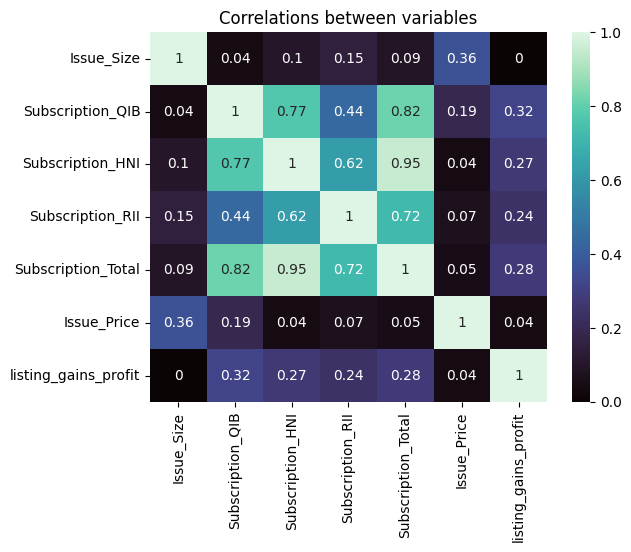

In [7]:
# heatmap to check correlations
correlations = abs(round(data.corr(),2))
sns.heatmap(correlations, annot=True, cmap='mako')
plt.title('Correlations between variables')
plt.show()

The most notable correlations are:

*   Subscription total and subscription HNI
*   Subscription total and subscription QIB
*   Subscription HNI and subscription QIB

The total number of times an IPO was subscribed shows significant correlation with the types of subscriptions. Subscriptions for high net worth individuals and qualified institutional buyers are more related to each other than they are to subscriptions by retail individual investors. The target variable appears to have little correlation with issue size and issue price.

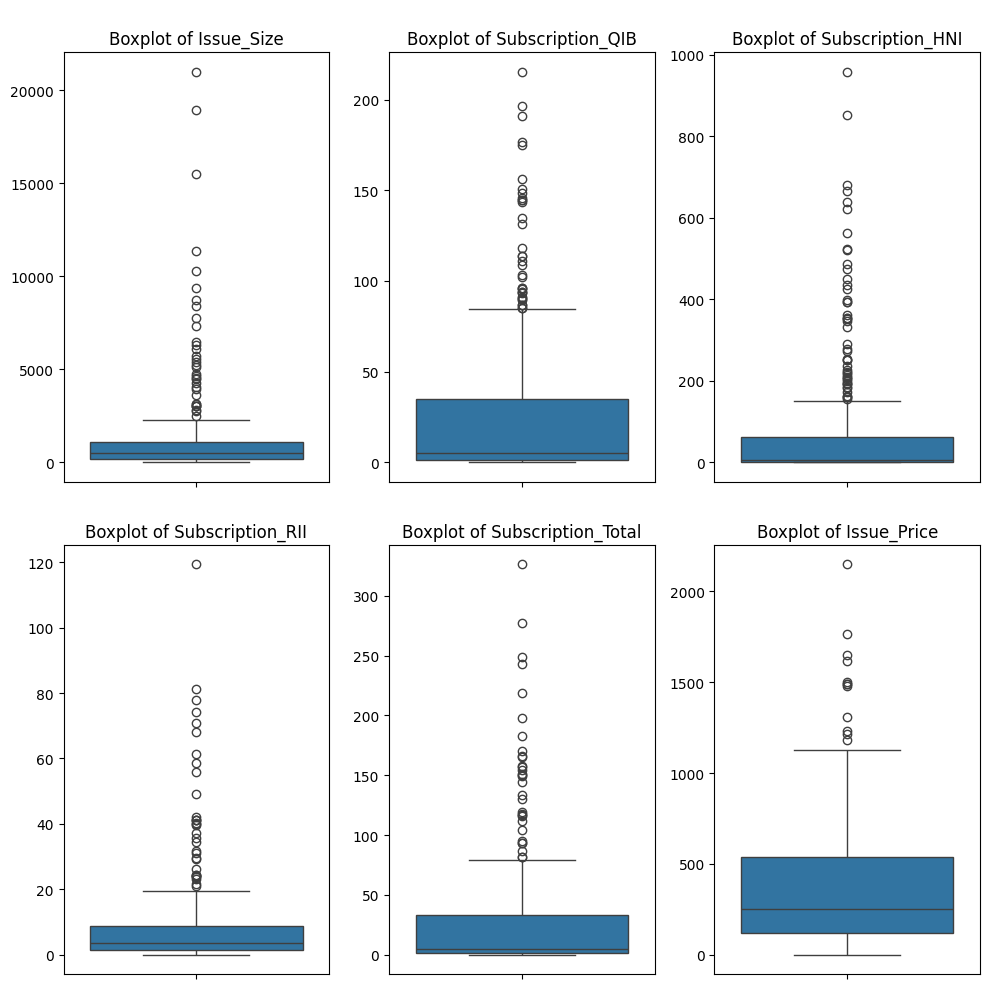

In [8]:
# use boxplots to visualize outliers
predictors = ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Issue_Price']

fig = plt.figure(figsize=(10, 10))

for i, col in enumerate(predictors):
    ax=fig.add_subplot(2, 3, i+1)
    sns.boxplot(data=data, y=col)
    ax.set_title(f'\nBoxplot of {col}')
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Outlier Treatment
The boxplots show that all of the variables have many outliers in the positive direction. The outliers will be replaced by the upper bound using the interquartile method.

In [9]:
# calculate upper bound
for col in predictors:
  stats = data[col].describe()
  iqr = stats['75%'] - stats['25%']
  upper = stats['75%'] + 1.5*iqr

# replace outliers with upper bound
  data.loc[data[col] > upper, col] = upper

# view updated statistics
data[predictors].describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,763.561238,21.521183,40.356426,6.060940,20.456646,362.147335
std,769.689122,29.104549,57.427921,6.176882,27.217740,312.272967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000
50%,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000
75%,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000
max,2496.492500,84.862500,153.355000,19.600000,81.020000,1161.500000


## Holdout Validation Approach
The data needs to be scaled and split into training and test sets. The training set will use 70% of the data to teach the model, and the testing set will use the remaining 30% of the data to check how accurate the model is.

In [10]:
# setting variables and scaling data
target_variable = ['listing_gains_profit']
data[predictors] = data[predictors]/data[predictors].max()
data.describe()
X = data[predictors].values
y = data[target_variable].values

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

## The Deep Learning Classification Model

It's time to create an instance of the model and add hidden layers that will perform calculations behind the curtain. The model will be compiled using the specified optimizer, loss function, and evaluation metric, then trained on the training data.

In [11]:
# define model
tf.random.set_seed(100)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 929 (3.63 KB)
Trainable params: 929 (3.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# train model
model.fit(X_train, y_train, epochs=150)

Epoch 1/150
7/7 [==============================] - 1s 5ms/step - loss: 0.6862 - accuracy: 0.5471
Epoch 2/150
7/7 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5561
Epoch 3/150
7/7 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5561
Epoch 4/150
7/7 [==============================] - 0s 5ms/step - loss: 0.6707 - accuracy: 0.5561
Epoch 5/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6671 - accuracy: 0.5561
Epoch 6/150
7/7 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.5561
Epoch 7/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6589 - accuracy: 0.5561
Epoch 8/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6555 - accuracy: 0.5561
Epoch 9/150
7/7 [==============================] - 0s 5ms/step - loss: 0.6512 - accuracy: 0.5561
Epoch 10/150
7/7 [==============================] - 0s 5ms/step - loss: 0.6479 - accuracy: 0.5561
Epoch 11/150
7/7 [===========

## Model Evaluation

The model's accuracy will be calculated for both the training and test sets.

In [13]:
print('Training set:')
model.evaluate(X_train, y_train)
print('Test set:')
model.evaluate(X_test, y_test)

Training set:
7/7 [==============================] - 0s 3ms/step - loss: 0.5601 - accuracy: 0.7130
Test set:
3/3 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.7188


[0.6522498726844788, 0.71875]

## Conclusion

The model has achieved a test accuracy of 71.88% and a training accuracy of 71.30%. The fact that the numbers are similar suggests that there is not a problem with overfitting. The investment firm can now use the model to choose which IPOs to invest in.